In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
from ADlasso2 import AD2_w_utils_weightdiff as ad

## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [2]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_weight\Level2\tuning_weight_tol=1e-6")

In [3]:
def ignore_section_lambda_decision(tuning_dict, celltype, k_seg, start_idx=0, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
    
    # start index should be the index of lambda at which the BCE curve does not look strange
    if start_idx > 0:
        print('Start index:', start_idx)
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] == 0:
            cut_idx = i
            print('Cut index:', cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][start_idx:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, start_idx=0, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        # vertical line for start lambda (blue)
        if start_idx > 0:
            # only plot the start line when the start_idx is not the first index
            print('Start:', np.exp(tuning['log_lambda_range'][start_idx]))
            # vertical line for start lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][start_idx]), color = 'blue', linestyle=':')
        # vertical line for cut lambda (red)
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0 (this does not make sense with y log scale)
        # plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")  # set log scale for feature number
        ax2.set_ylim(bottom=0.5, top=None)  # set ylim for feature number  # EDITTED
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    # TODO: reset k value of lambda decision
    opt_lmbd, candidates, fig = ad.lambda_decision(trimmed_tuning, k=k_seg, savepath=output_dir + f'{celltype}_lambda_decision_trimmed.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, start_idx=start_idx, savepath=output_dir + f'{celltype}_lambda_decision_all.png')

    return opt_lmbd, feature_no_celltype

In [4]:
opt_lmbd_dict = {}
feature_no_dict = {}

In [5]:
queue = ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']

In [6]:
### Function for running lambda decision for a single cell types
def run_lmbd_decision(celltype, k_seg, start_idx=0, output_dir=''):
    tuning_file = f'{celltype}_tuning.json'
    if not os.path.exists(tuning_file):
        print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
        return

    print('====================')
    print(f'Cell type: {celltype}')
    with open(tuning_file) as f:
        tuning = json.load(f)

    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, k_seg=k_seg, start_idx=start_idx, version='old', output_dir=output_dir)
    opt_lmbd_dict[celltype] = opt_lmbd
    feature_no_dict[celltype] = feature_no_celltype

ASDC Start index: 0
Cell type: ASDC
Cut index: 18
Optimal lambda: 0.0014677992676220694
Feature no: 161
Cut: 0.010000000000000004
B_intermediate Start index: 0
Cell type: B_intermediate
Cut index: 23
Optimal lambda: 3.16227766016838e-05
Feature no: 8053
Cut: 0.0681292069057962
B_memory Start index: 0
Cell type: B_memory
Cut index: 23
Optimal lambda: 9.999999999999997e-06
Feature no: 8678
Cut: 0.0681292069057962
B_naive Start index: 0
Cell type: B_naive
Optimal lambda: 0.00031622776601683783
Feature no: 515
CD14_Mono Start index: 0
Cell type: CD14_Mono
Optimal lambda: 0.014677992676220709
Feature no: 18
CD16_Mono Start index: 0
Cell type: CD16_Mono
Optimal lambda: 0.0021544346900318843
Feature no: 729
CD4_CTL Start index: 0
Cell type: CD4_CTL
Cut index: 20
Optimal lambda: 0.00031622776601683783
Feature no: 1478
Cut: 0.02154434690031885
CD4_Naive Start index: 0
Cell type: CD4_Naive
Cut index: 24
Optimal lambda: 2.1544346900318854e-05
Feature no: 7993
Cut: 0.10000000000000002
CD4_Prolifer

C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\ADlasso2\AD2_w_utils_weightdiff.py:979: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize = (fig_width, fig_height))


Optimal lambda: 0.0002154434690031884
Feature no: 2335
Cut: 0.0316227766016838
CD8_Naive Start index: 0
Cell type: CD8_Naive
Cut index: 23
Optimal lambda: 9.999999999999991e-05
Feature no: 3509
Cut: 0.0681292069057962
CD8_Proliferating Start index: 0
Cell type: CD8_Proliferating
Cut index: 18
Optimal lambda: 3.16227766016838e-05
Feature no: 8886
Cut: 0.010000000000000004
CD8_TCM Start index: 0
Cell type: CD8_TCM
Cut index: 21
Optimal lambda: 0.00031622776601683783
Feature no: 1600
Cut: 0.0316227766016838
CD8_TEM Start index: 0
Cell type: CD8_TEM
Cut index: 24
Optimal lambda: 0.014677992676220709
Feature no: 19
Cut: 0.10000000000000002
Doublet Start index: 0
Cell type: Doublet
Cut index: 20
Optimal lambda: 0.00031622776601683783
Feature no: 2612
Cut: 0.02154434690031885
Eryth Start index: 0
Cell type: Eryth
Cut index: 21
Optimal lambda: 0.00014677992676220703
Feature no: 1582
Cut: 0.0316227766016838
HSPC Start index: 0
Cell type: HSPC
Cut index: 22
Optimal lambda: 0.00014677992676220703

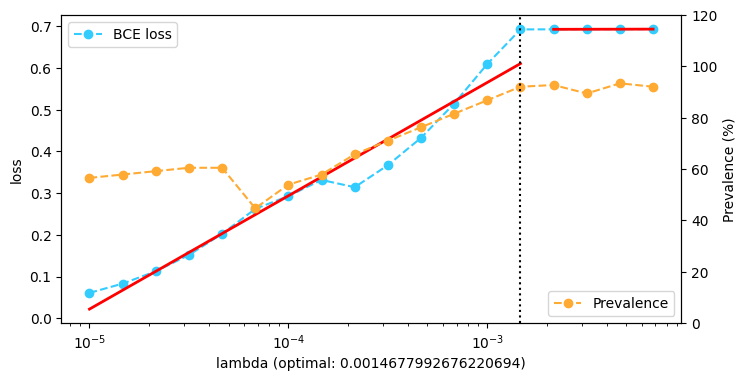

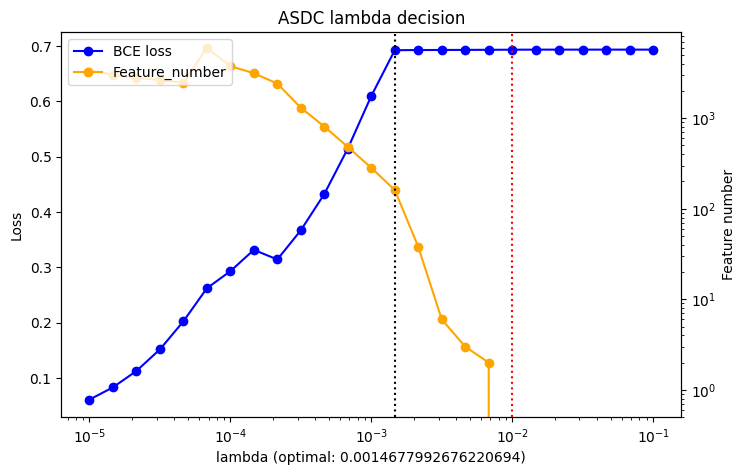

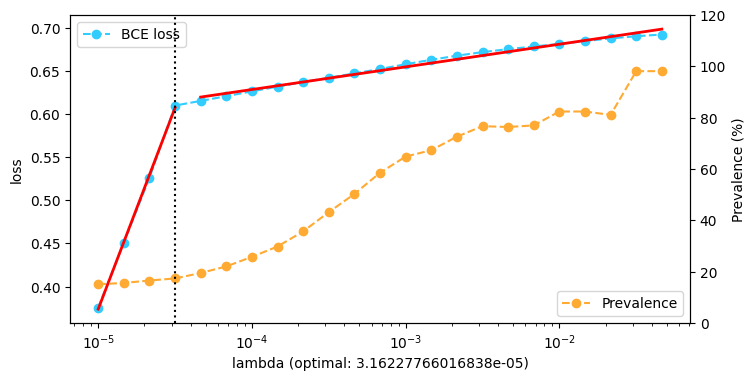

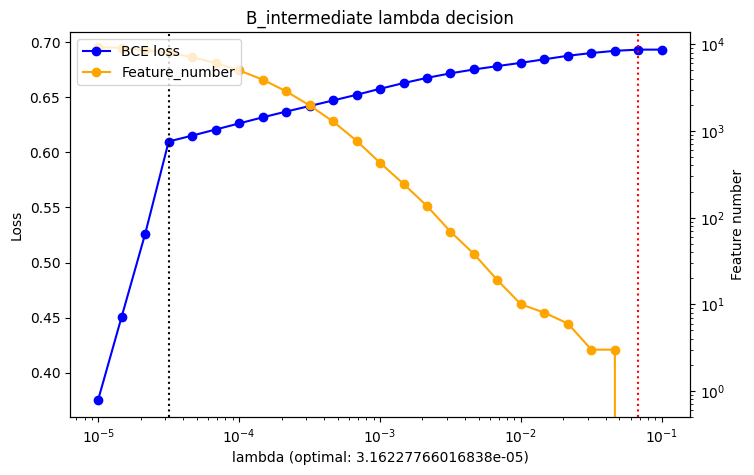

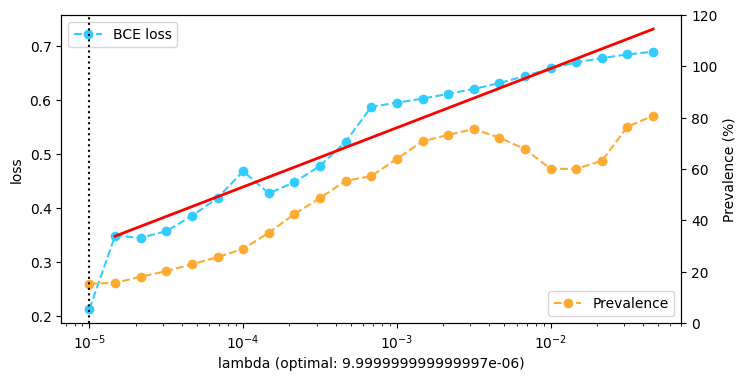

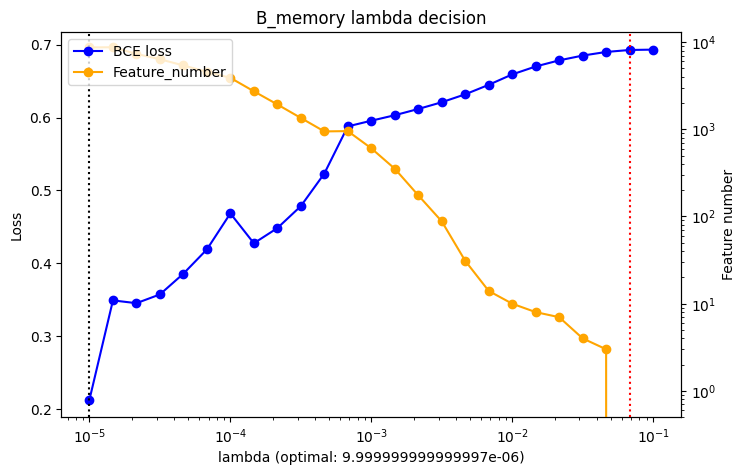

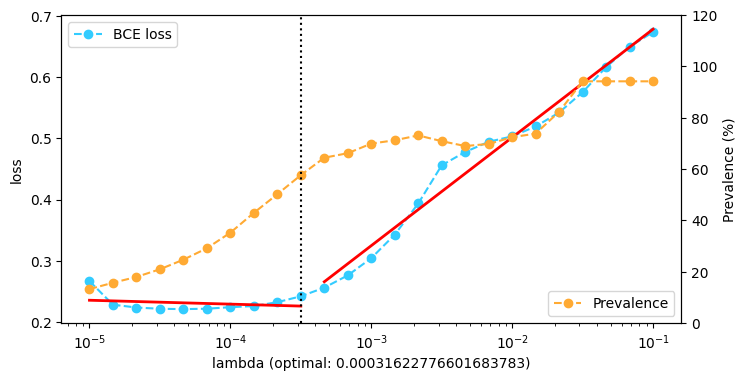

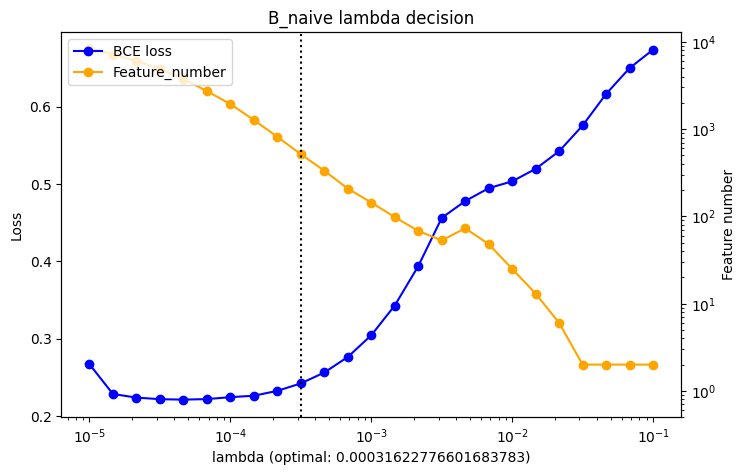

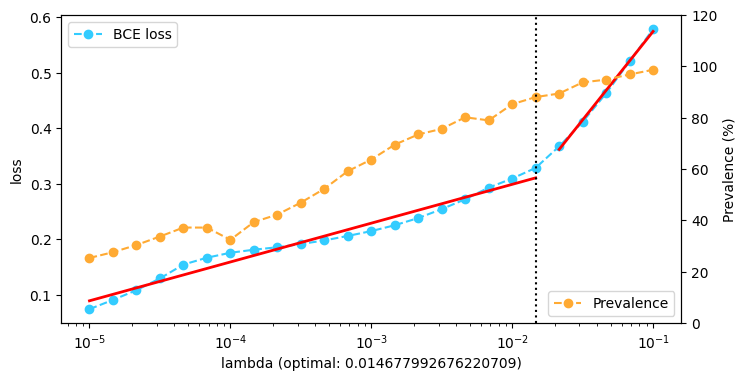

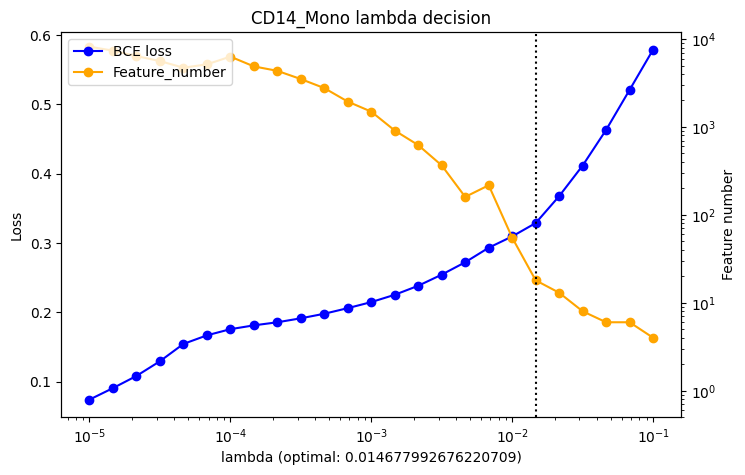

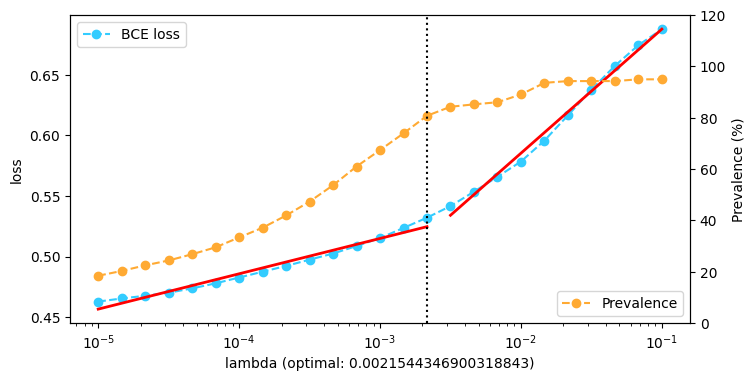

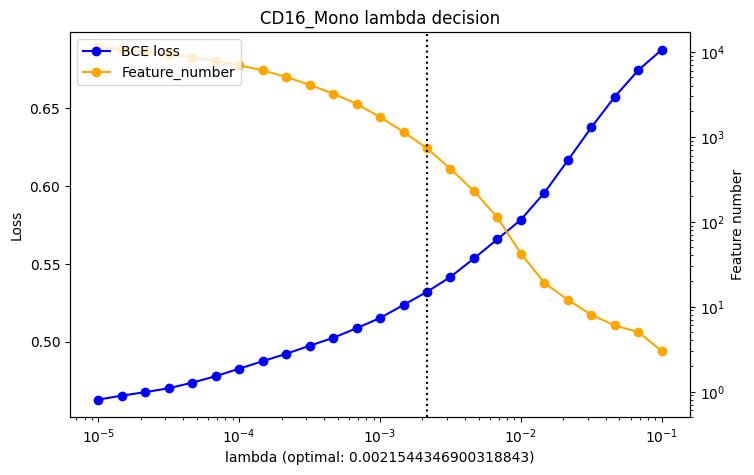

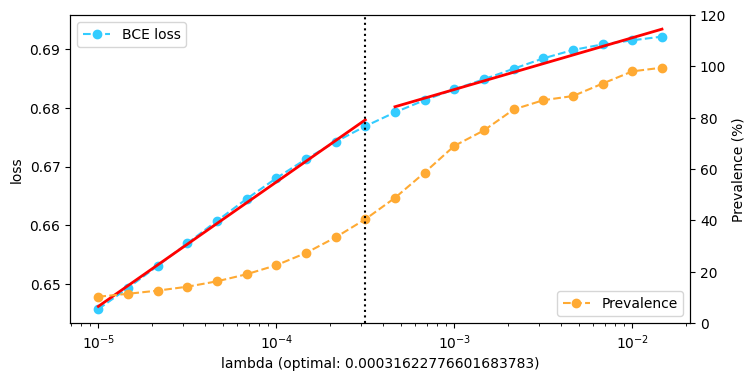

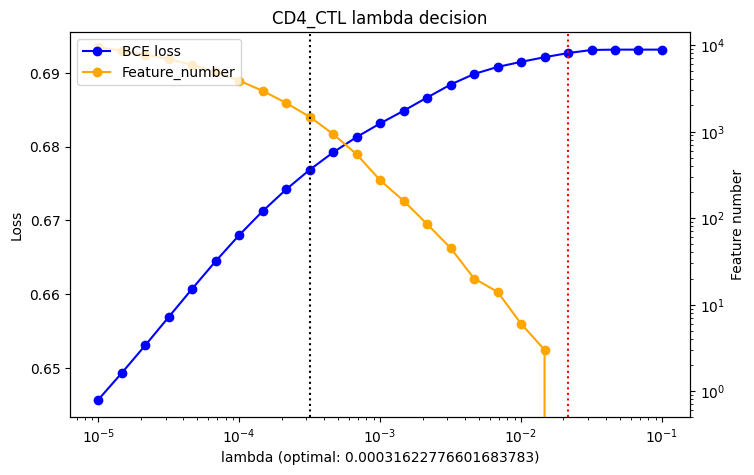

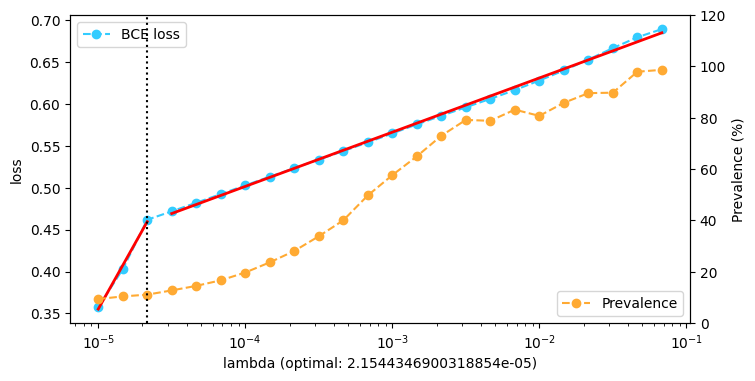

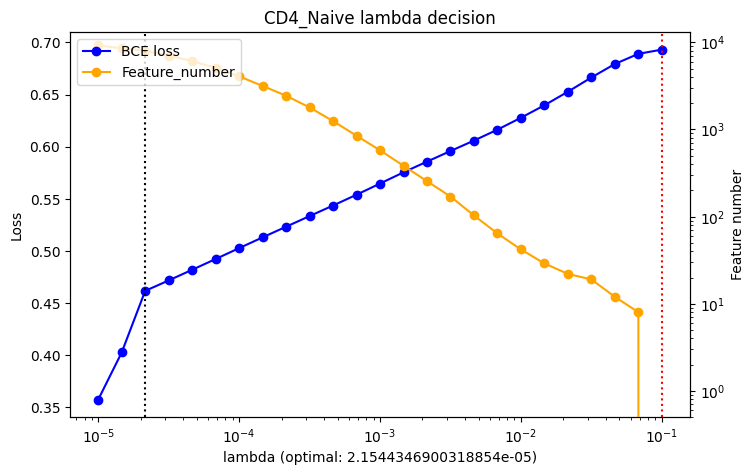

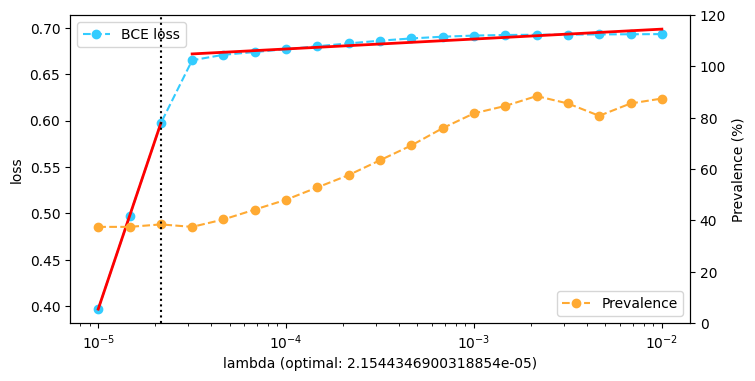

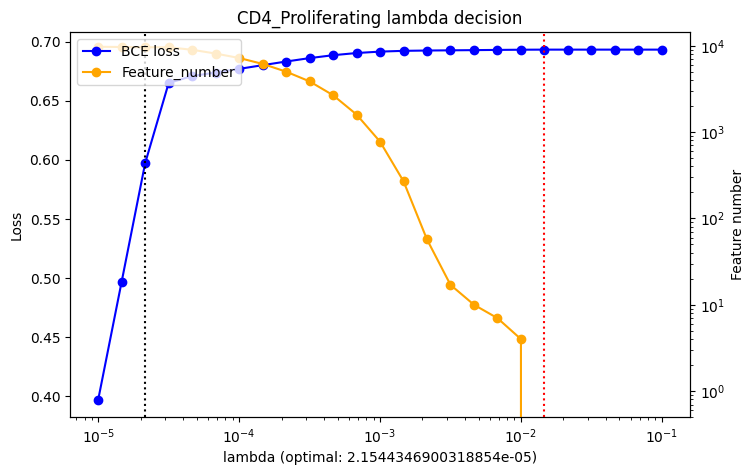

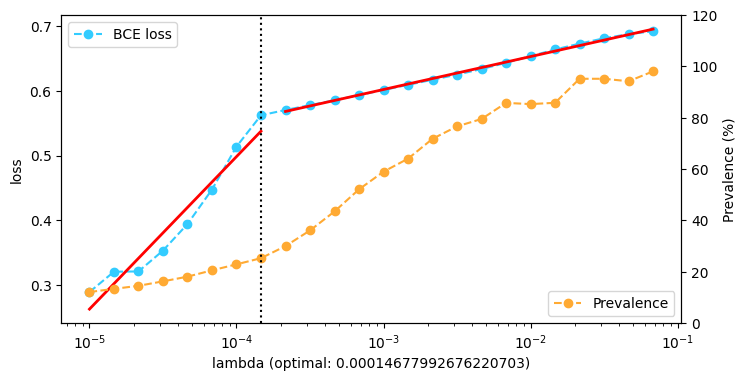

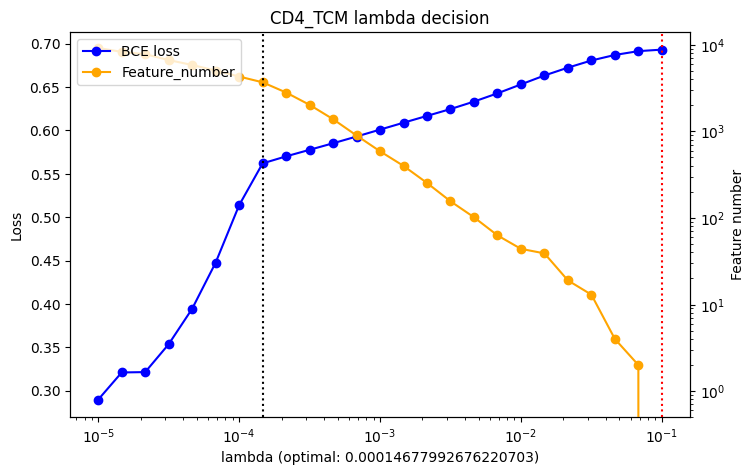

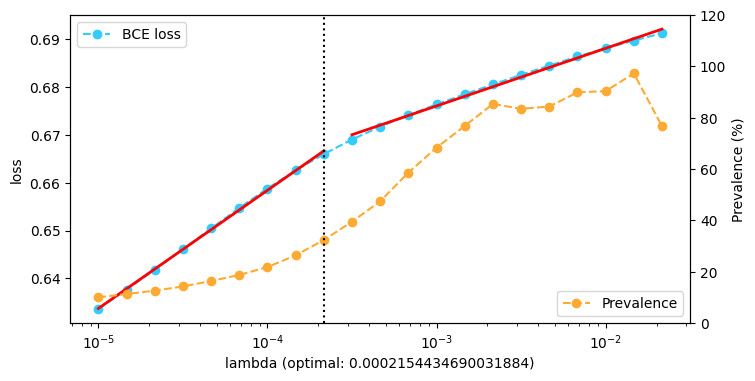

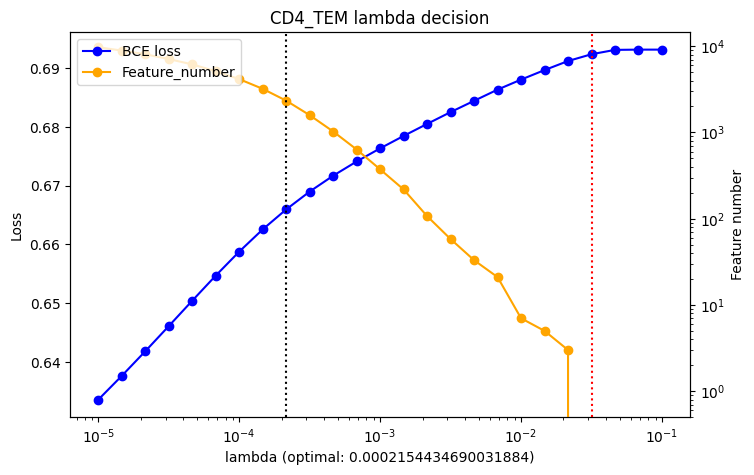

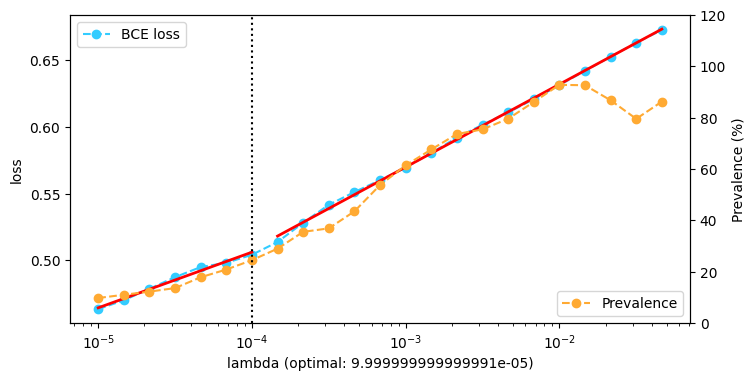

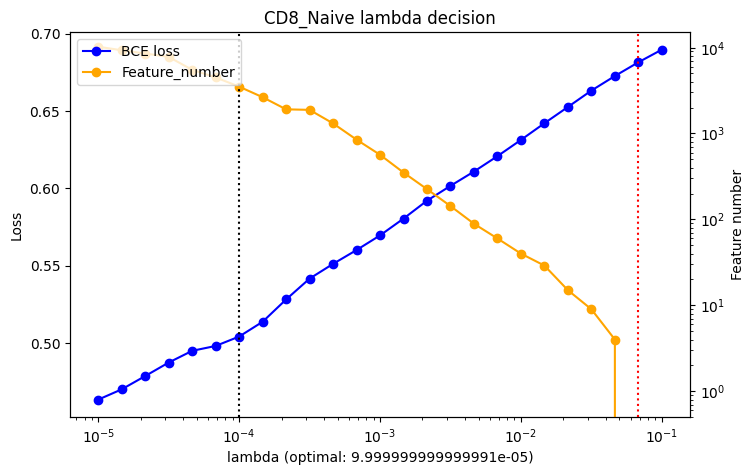

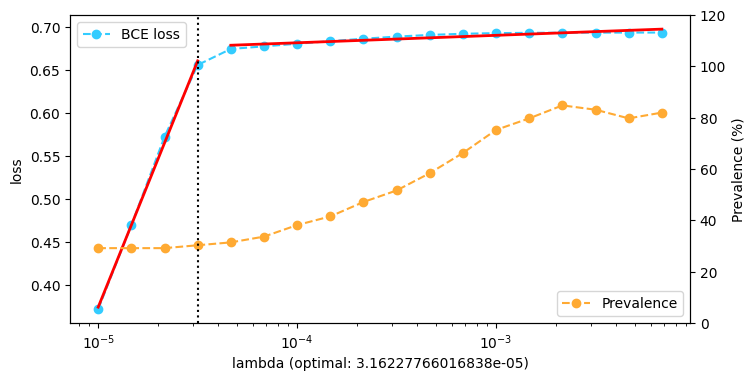

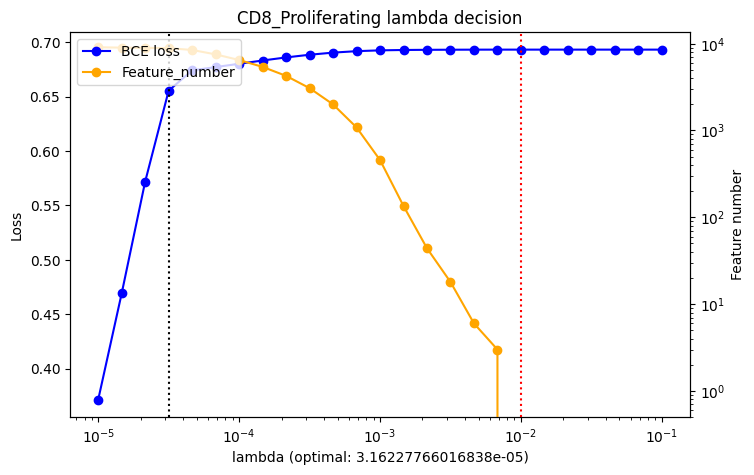

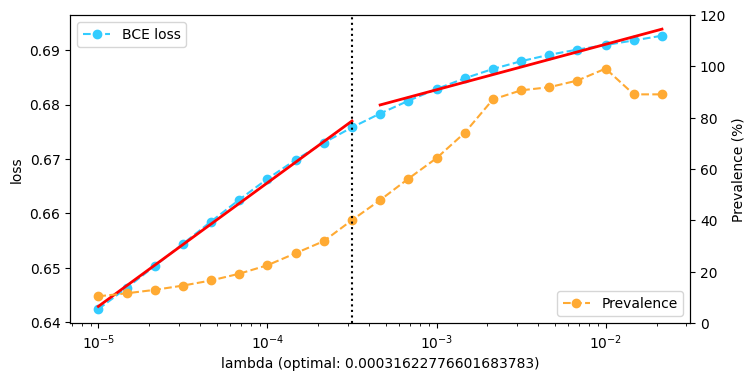

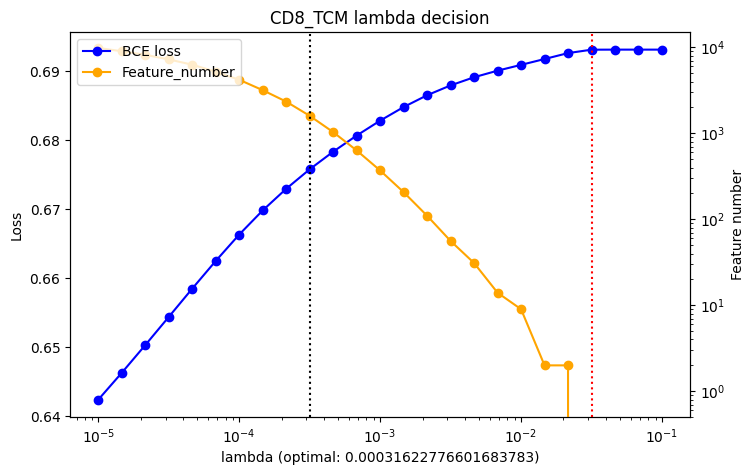

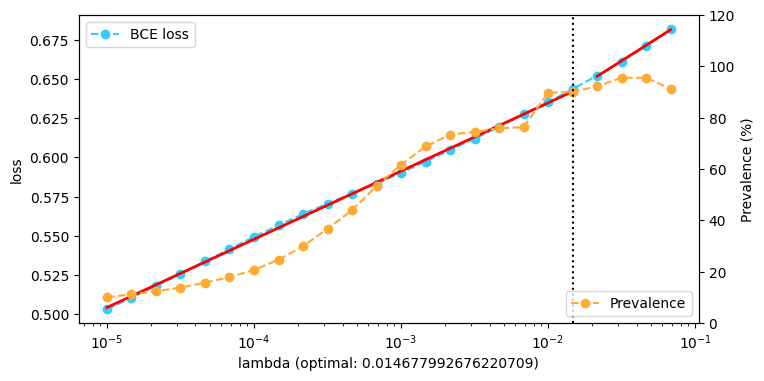

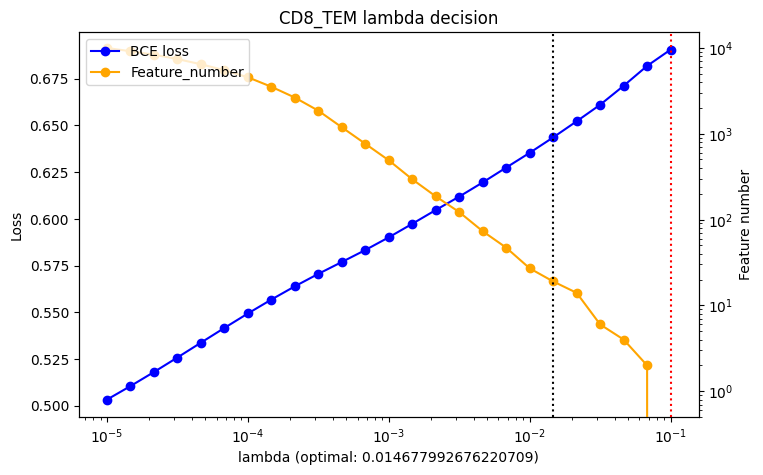

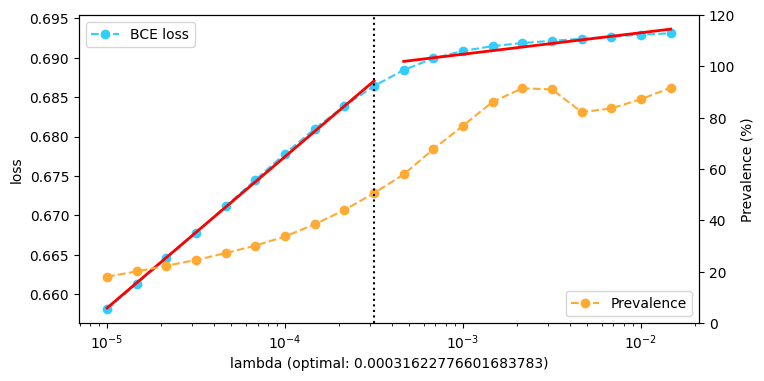

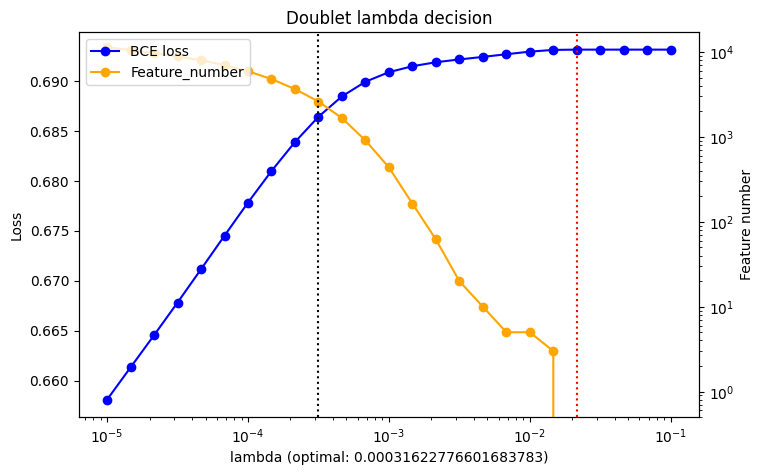

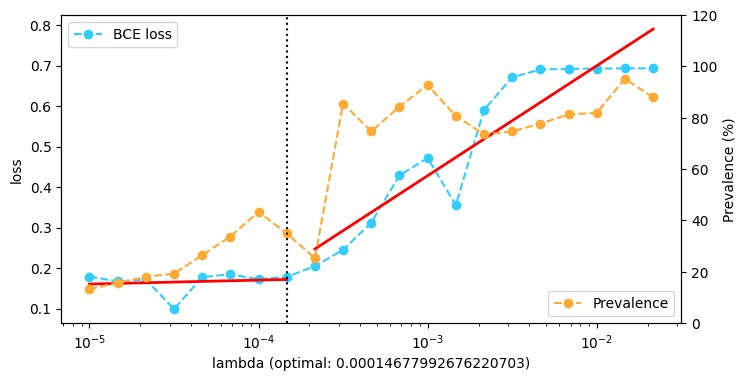

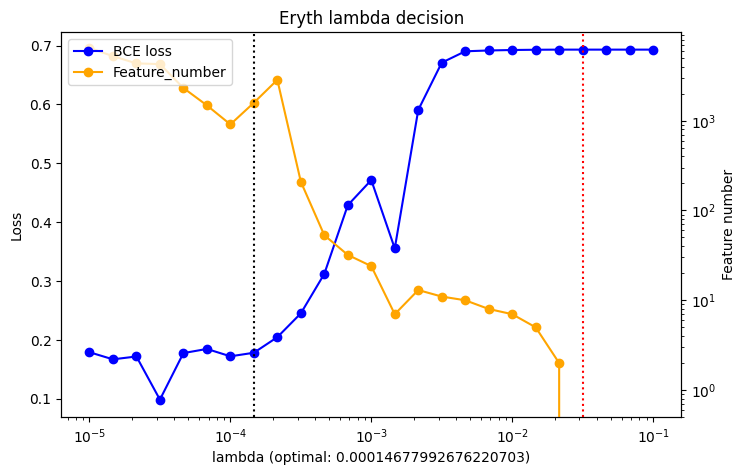

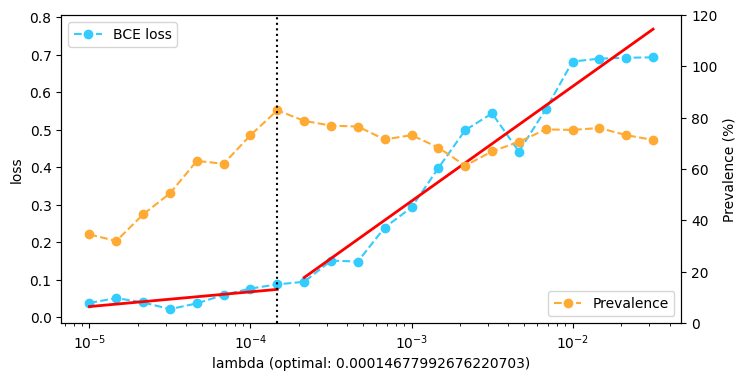

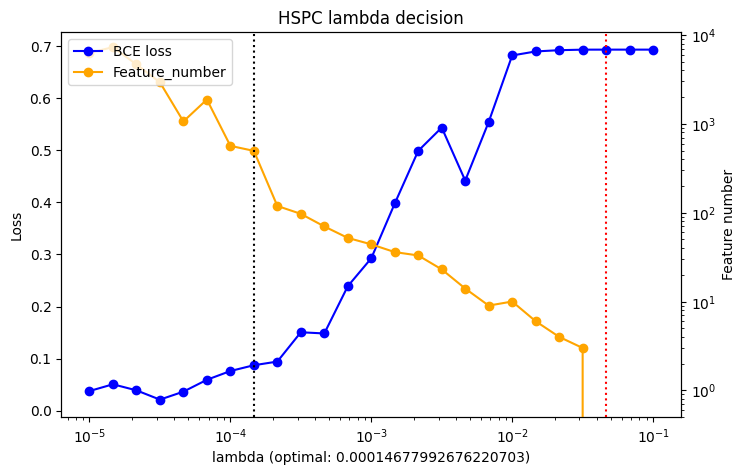

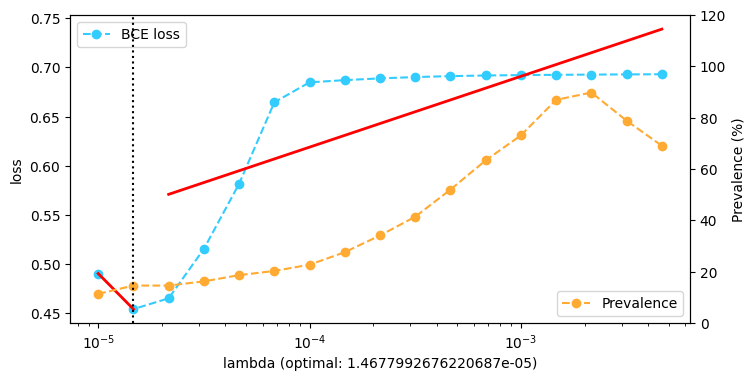

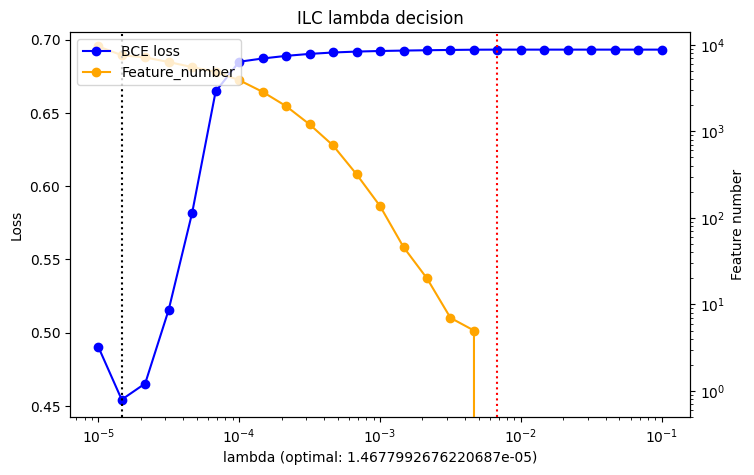

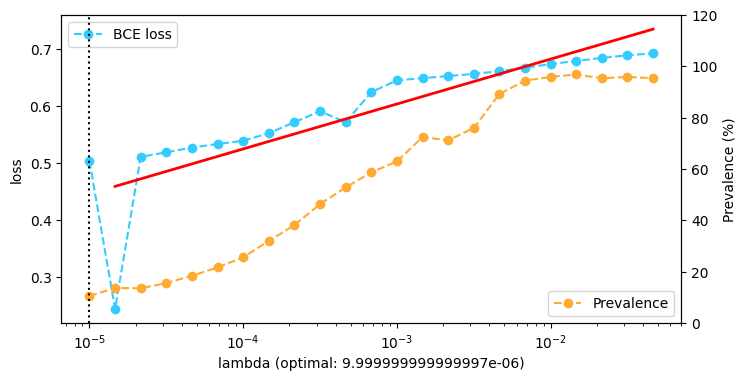

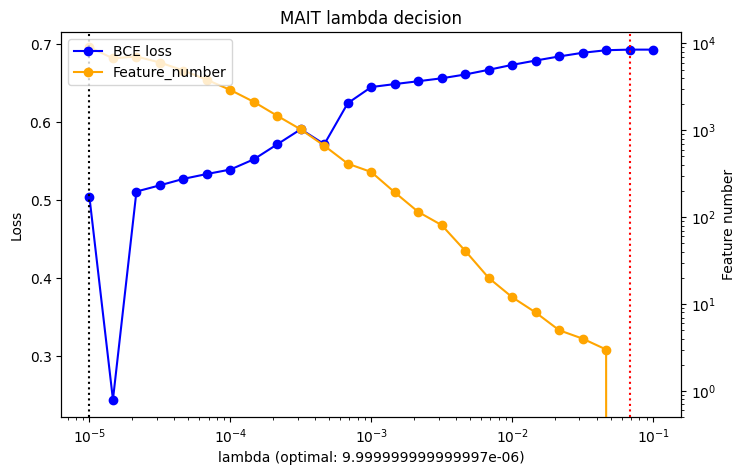

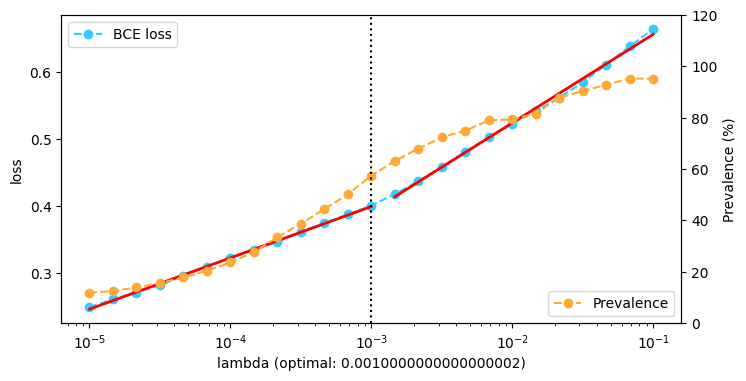

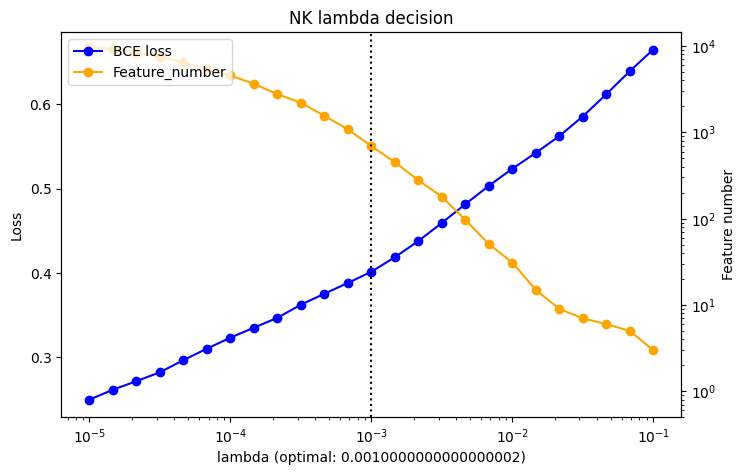

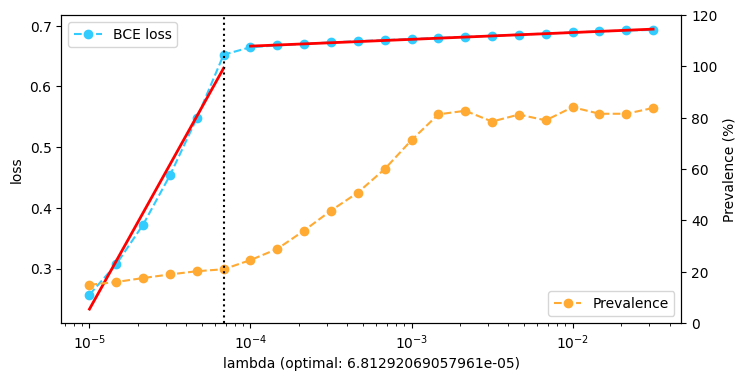

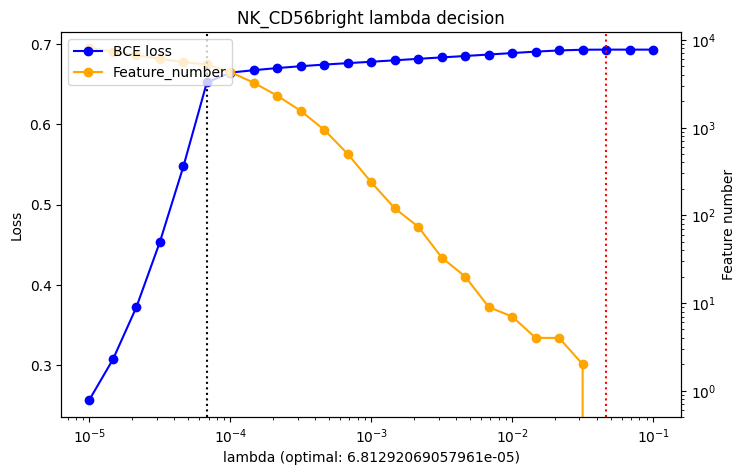

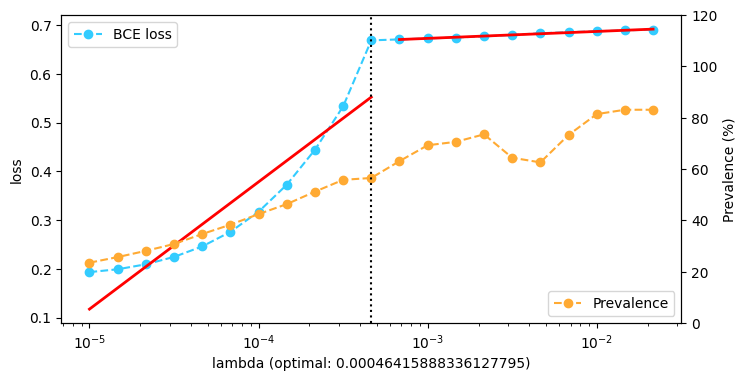

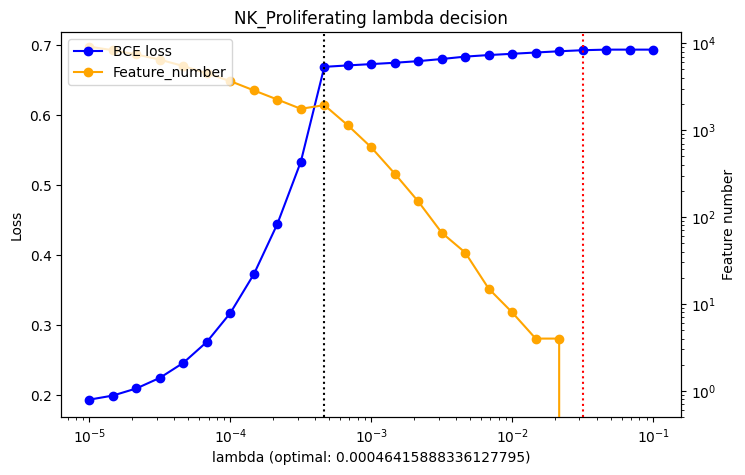

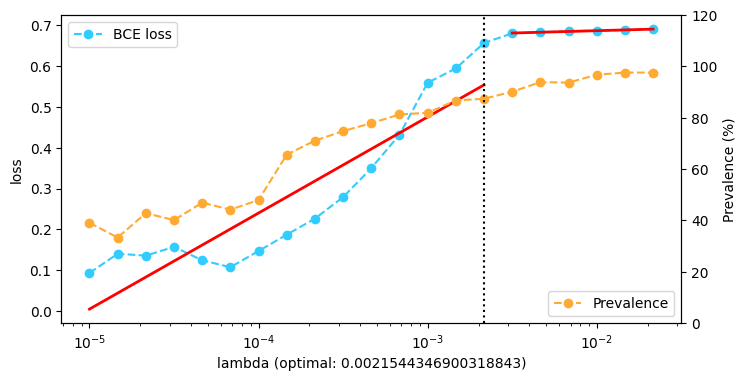

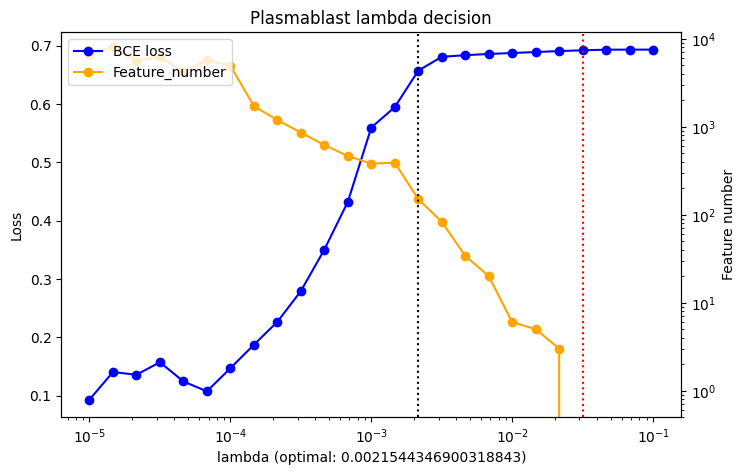

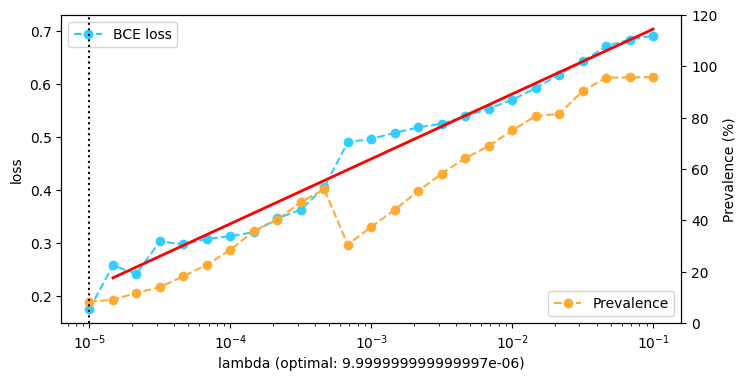

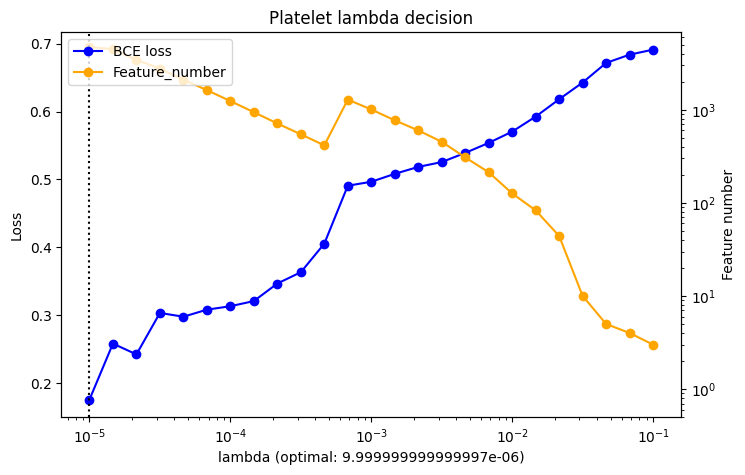

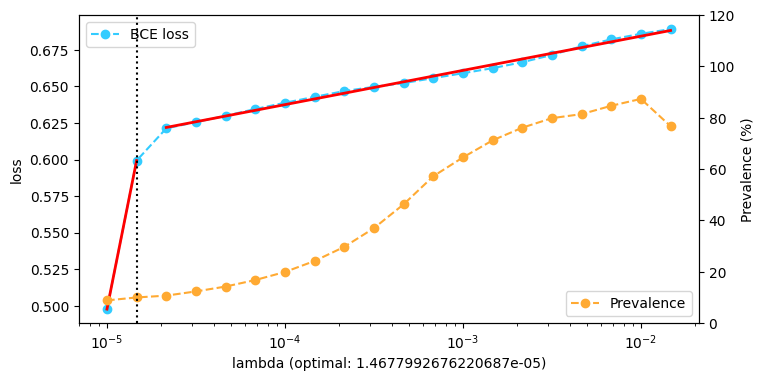

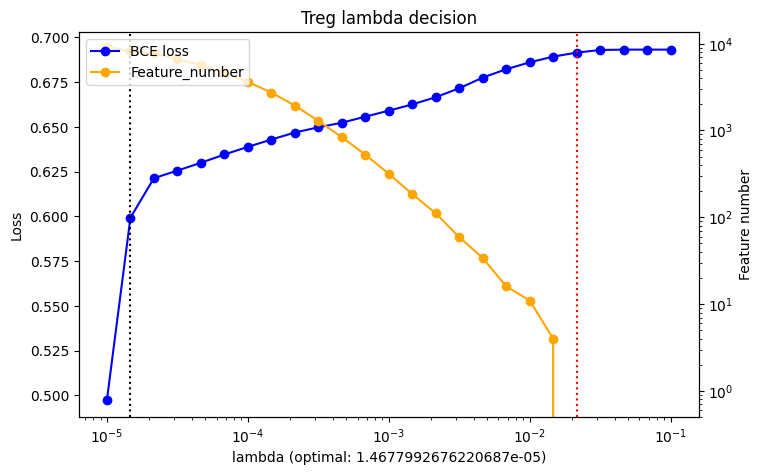

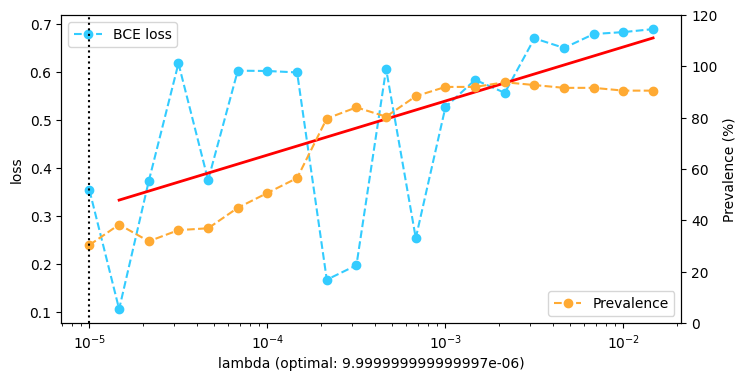

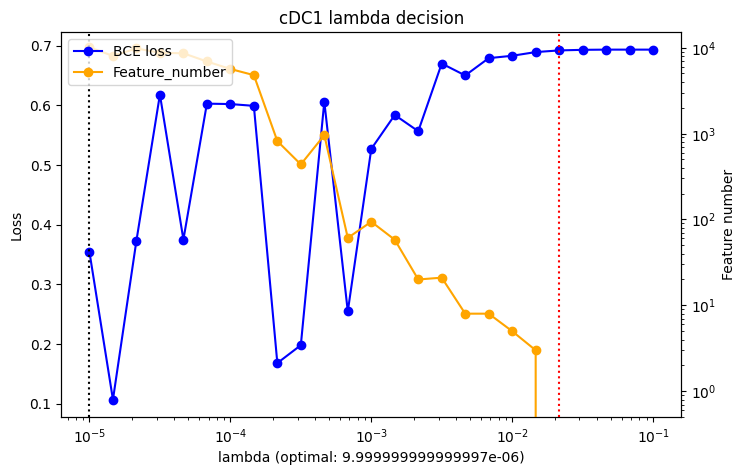

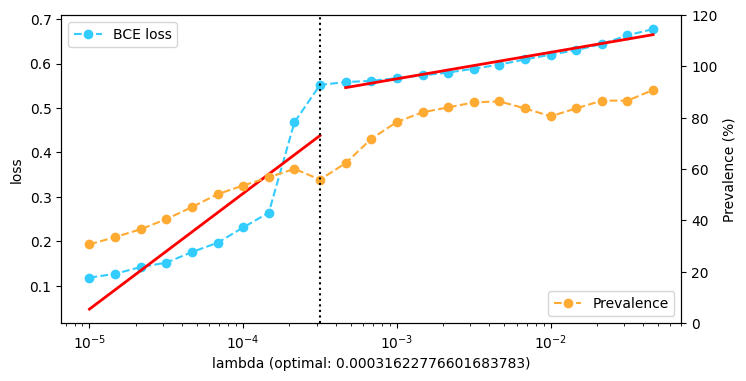

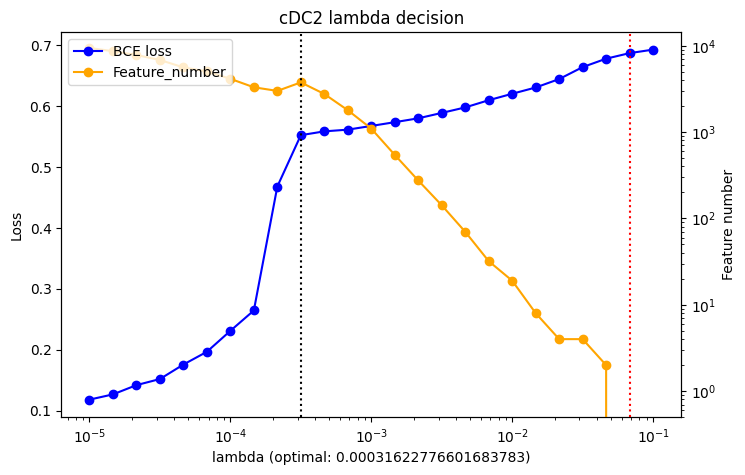

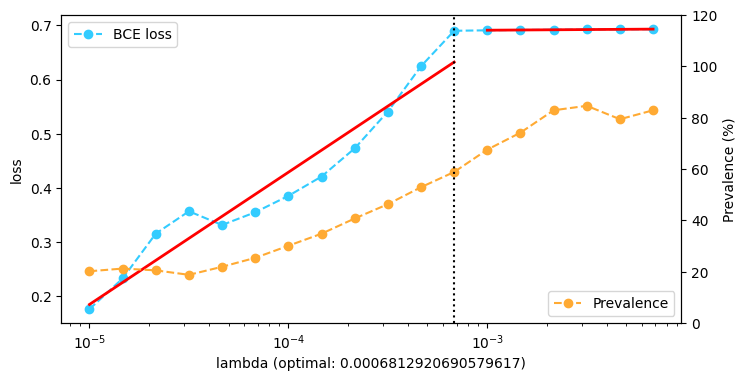

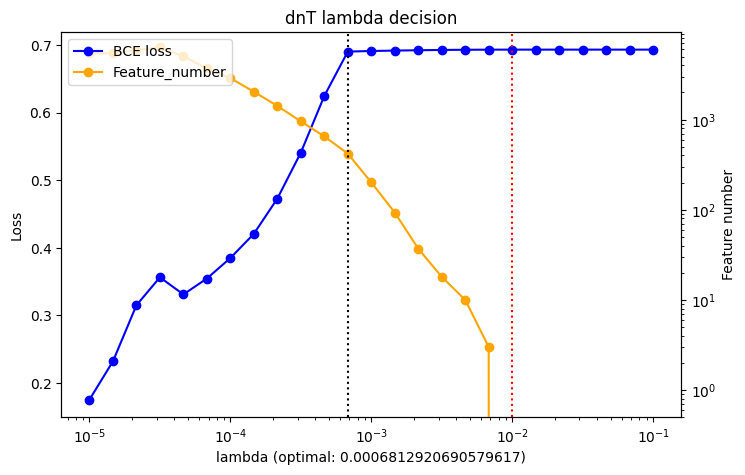

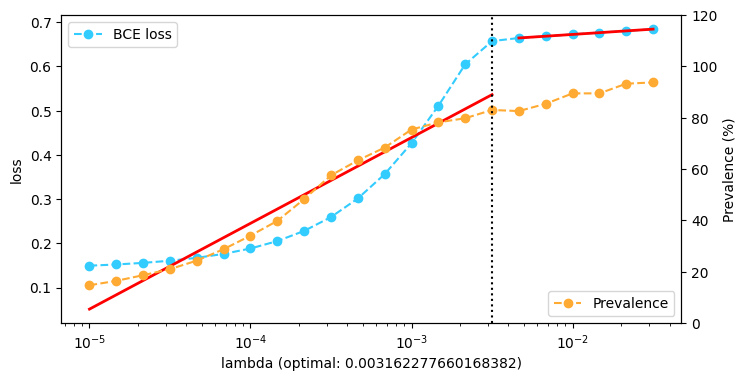

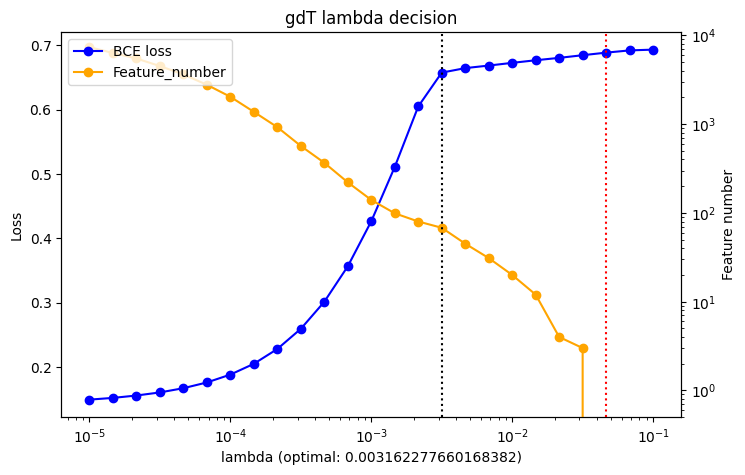

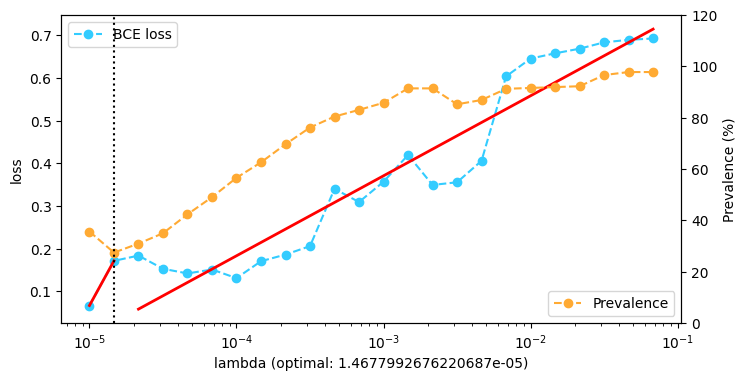

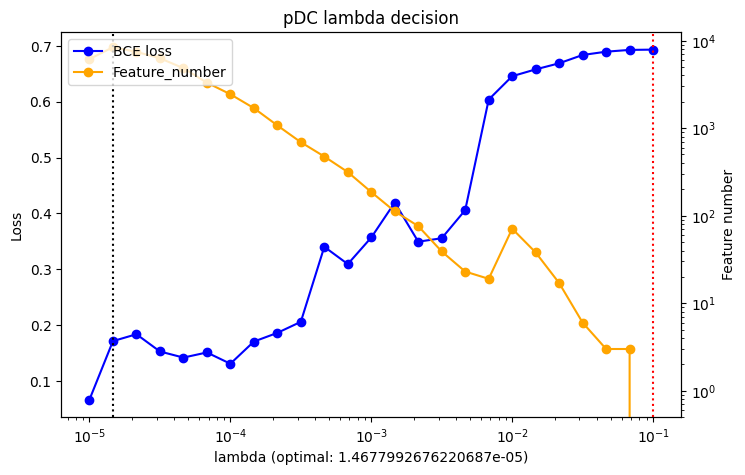

In [7]:
# Start index for each cell type
start_idx_dict = {
    # 'DC': 2, 
    # 'other_T': 11
}

dir = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans_weight\Level2\lambda_decision" + '\\'
for celltype in queue:
    start_idx = start_idx_dict.get(celltype, 0)
    print('====================')
    print(celltype, 'Start index:', start_idx)
    run_lmbd_decision(celltype, k_seg=2, start_idx=start_idx, output_dir=dir)

In [8]:
opt_lmbd_dict

{'ASDC': 0.0014677992676220694,
 'B_intermediate': 3.16227766016838e-05,
 'B_memory': 9.999999999999997e-06,
 'B_naive': 0.00031622776601683783,
 'CD14_Mono': 0.014677992676220709,
 'CD16_Mono': 0.0021544346900318843,
 'CD4_CTL': 0.00031622776601683783,
 'CD4_Naive': 2.1544346900318854e-05,
 'CD4_Proliferating': 2.1544346900318854e-05,
 'CD4_TCM': 0.00014677992676220703,
 'CD4_TEM': 0.0002154434690031884,
 'CD8_Naive': 9.999999999999991e-05,
 'CD8_Proliferating': 3.16227766016838e-05,
 'CD8_TCM': 0.00031622776601683783,
 'CD8_TEM': 0.014677992676220709,
 'Doublet': 0.00031622776601683783,
 'Eryth': 0.00014677992676220703,
 'HSPC': 0.00014677992676220703,
 'ILC': 1.4677992676220687e-05,
 'MAIT': 9.999999999999997e-06,
 'NK': 0.0010000000000000002,
 'NK_CD56bright': 6.81292069057961e-05,
 'NK_Proliferating': 0.00046415888336127795,
 'Plasmablast': 0.0021544346900318843,
 'Platelet': 9.999999999999997e-06,
 'Treg': 1.4677992676220687e-05,
 'cDC1': 9.999999999999997e-06,
 'cDC2': 0.0003162

In [9]:
feature_no_dict

{'ASDC': 161,
 'B_intermediate': 8053,
 'B_memory': 8678,
 'B_naive': 515,
 'CD14_Mono': 18,
 'CD16_Mono': 729,
 'CD4_CTL': 1478,
 'CD4_Naive': 7993,
 'CD4_Proliferating': 9589,
 'CD4_TCM': 3697,
 'CD4_TEM': 2335,
 'CD8_Naive': 3509,
 'CD8_Proliferating': 8886,
 'CD8_TCM': 1600,
 'CD8_TEM': 19,
 'Doublet': 2612,
 'Eryth': 1582,
 'HSPC': 496,
 'ILC': 7563,
 'MAIT': 9035,
 'NK': 696,
 'NK_CD56bright': 5239,
 'NK_Proliferating': 1935,
 'Plasmablast': 150,
 'Platelet': 4709,
 'Treg': 8123,
 'cDC1': 10088,
 'cDC2': 3760,
 'dnT': 419,
 'gdT': 68,
 'pDC': 8403}

In [10]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_ztrans\Level1_v4_a0.01_-5-0')
# with open('L1c_a0.01_k2_opt_lmbd.json', 'w') as f:
#     json.dump(opt_lmbd_dict, f)